In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
from scipy import stats,optimize
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
import math
from noaa_sdk import noaa

/home/robin/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
raw_spiro = pd.read_csv('raw_spiro.csv',parse_dates=['Date'])
raw_spiro.set_index(['Date','Hour'],inplace=True)
raw_spiro = raw_spiro.drop(['Time'], axis=1)
raw_spiro.head()
#old data, new index

PEF(l/min)  FEV1(l)  unixDate  unixTime
Date       Hour                                         
2020-02-20 10           219     1.72   18312.0   36720.0
           11           253     1.78   18312.0   42300.0
2020-02-21 3            388     2.54   18313.0   12660.0
           0            415     2.89   18313.0     480.0
2020-02-22 19           476     2.78   18314.0   70320.0

In [10]:
raw_spiro.index.get_level_values("Date").max()

Timestamp('2020-04-01 00:00:00')

In [27]:
def get_weather_data(zip_code,country,factors,
                     start=raw_spiro.index.get_level_values("Date").min().strftime('%Y-%m-%d'),
                     end=raw_spiro.index.get_level_values("Date").max().strftime('%Y-%m-%d')):
    n = noaa.NOAA()
    observations = n.get_observations(zip_code,country,start=start,end=end)
    df = pd.DataFrame()
    for observation in observations:
        observation_data = {k:v for (k,v) in observation.items() if k in factors}
        observation_values = {k:v['value'] for (k,v) in observation_data.items()}
        observation_values['time'] = pd.to_datetime(observation['timestamp'])#separate into date and hour
        df = df.append(observation_values, ignore_index=True)
    return df

In [29]:
factors = ['barometricPressure','precipitationLastHour','temperature','relativeHumidity']
weather = get_weather_data('11432','US',factors)
weather['precipitationLastHour'].fillna(0, inplace=True)
weather['Date'] = [d.date() for d in weather['time']]
weather['Hour'] = [d.hour for d in weather['time']]
weather.set_index(['Date','Hour'],inplace=True)
weather.head()

barometricPressure  precipitationLastHour  relativeHumidity  \
Date       Hour                                                                
2020-04-01 23              100710.0                    0.0         38.984929   
           22              100680.0                    0.0         36.243091   
           21              100640.0                    0.0         33.788524   
           20              100640.0                    0.0         35.246635   
           19              100640.0                    0.0         36.661559   

                 temperature                time  
Date       Hour                                   
2020-04-01 23           10.6 2020-04-01 23:51:00  
           22           11.7 2020-04-01 22:51:00  
           21           12.2 2020-04-01 21:51:00  
           20           12.8 2020-04-01 20:51:00  
           19           12.2 2020-04-01 19:51:00

In [30]:
weather_spiro = weather.join(raw_spiro,how='inner').dropna()
weather_spiro = weather_spiro.reset_index()
weather_spiro.to_csv('weather_spiro.csv',index=False)
weather_spiro.head()


,Date,Hour,barometricPressure,precipitationLastHour,relativeHumidity,temperature,time,PEF(l/min),FEV1(l),unixDate,unixTime
0,2020-02-22,19,102200.0,0.0,18.705038,10.0,2020-02-22 19:51:00,476,2.78,18314.0,70320.0
1,2020-02-23,5,102300.0,0.0,66.125542,0.6,2020-02-23 05:51:00,294,1.62,18315.0,18780.0
2,2020-02-23,15,102340.0,0.0,35.825672,9.4,2020-02-23 15:51:00,384,2.49,18315.0,56220.0
3,2020-02-24,4,101970.0,0.0,64.445125,3.9,2020-02-24 04:51:00,382,2.93,18316.0,15240.0
4,2020-02-24,15,101830.0,0.0,60.763303,9.4,2020-02-24 15:51:00,502,2.92,18316.0,55560.0


In [149]:
Y = weather_spiro['PEF(l/min)']
X = weather_spiro[['barometricPressure','precipitationLast3Hours','relativeHumidity','temperature',
                   'unixDate','unixTime']]

mod = sm.OLS(Y,X)
fit = mod.fit()
summary = fit.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             PEF(l/min)   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              839.3
Date:                Fri, 03 Apr 2020   Prob (F-statistic):                   1.59e-149
Time:                        13:13:57   Log-Likelihood:                         -1330.7
No. Observations:                 228   AIC:                                      2673.
Df Residuals:                     222   BIC:                                      2694.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
barometricPressure          0.0048      0.008      0.585      0.559      -0.011       0.021
precipitationLast3Hours -3.998e+04   2.68e+04     -1.494      0.137   -9.27e+04    1.27e+04
relativeHumidity            0.3954      0.261      1.513      0.132      -0.120       0.911
temperature                 0.0355      1.532      0.023      0.982      -2.984       3.055
unixDate                   -0.0076      0.046     -0.166      0.869      -0.098       0.083
unixTime                    0.0005      0.000      2.112      0.036    3.29e-05       0.001
==============================================================================
Omnibus:                        2.409   Durbin-Watson:                   1.577
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                2.350
Skew:                           0.188   Prob(JB):                        0.309
Kurtosis:                       2.676   Cond. No.                     5.49e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [218]:
#find what sorts of reports are available for what area
#https://docs.airnowapi.org/Data/query
#http://www.airnowapi.org/aq/data/?startDate=2020-02-21T13&endDate=2020-03-26T14&parameters=OZONE,PM25,PM10,CO,NO2,SO2&BBOX=-73.870000,40.696253,-73.792409,40.762596&dataType=B&format=text/csv&verbose=1&nowcastonly=0&includerawconcentrations=1&API_KEY=
#to-do learn api format https://docs.airnowapi.org/Data/docs
#get other pollution concentrations
colnames=["Latitude","Longitude","UTC","Parameter","Concentration","Unit","Raw Concentration","AQI","Category",
    "Site Name","Site Agency","AQS ID","Full AQS ID"] 
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M')

#df = pd.read_csv(infile, parse_dates=['datetime'], date_parser=dateparse)

AQI = pd.read_csv('./Output.csv',parse_dates=['UTC'], date_parser=dateparse,names=colnames, header=None)
AQI = AQI[["UTC","Parameter","Concentration","AQI","Site Name"]]
#we have hourly results but we won't use all that data yet
AQI['UTC']=AQI['UTC'].apply(lambda x: datetime(year=x.year, month=x.month, day=x.day))
AQI['unixDate']= AQI['UTC'].astype(np.int64)// 10**9
AQI['unixDate'] = AQI['unixDate']/86400

AQITotal = AQI[['unixDate','AQI']]
AQITotal.index = AQITotal['unixDate']
AQITotal = AQITotal.groupby(AQITotal['unixDate']).mean()
#AQITotal = AQITotal.drop(['unixDate'], axis=1)
AQI = AQI.drop(['AQI'], axis=1)


In [219]:
#ozone=ozone.rename(columns={"Concentration": "ozone"})
AQITotal.head()

,AQI
unixDate,
18313.0,22.272727
18314.0,27.638889
18315.0,34.902778
18316.0,40.250000
18317.0,31.708333


In [222]:
temp_spiro.head()

,PRCP,WT08,TAVG,Date,Time,PEF(l/min),FEV1(l),unixDate,unixTime
unixDate,,,,,,,,,
18314.0,0.0,0.0,38.0,2020/2/22,03:31:00,388,2.54,18314.0,12660.0
18314.0,0.0,0.0,38.0,2020/2/22,00:08:00,415,2.89,18314.0,480.0
18315.0,0.0,0.0,47.0,2020/2/23,19:32:00,476,2.78,18315.0,70320.0
18316.0,0.0,0.0,49.0,2020/2/24,05:13:00,294,1.62,18316.0,18780.0
18316.0,0.0,0.0,49.0,2020/2/24,15:37:00,384,2.49,18316.0,56220.0


In [220]:
def formatPollutionTables(pollutant,site=""):
    table = AQI.copy()
    table = table.where(table['Parameter']==pollutant)
    table = table.rename(columns={"Concentration":pollutant+site})
    if (pollutant == 'PM2.5'):
        table = table.where(table["Site Name"]==site).dropna()
    return table.groupby(table['unixDate']).mean()

ozone = formatPollutionTables("OZONE")
PM25 = formatPollutionTables("PM2.5","Queens")
PM25Road = formatPollutionTables("PM2.5","Queens Near-road")

In [225]:
raw_spiro.index=raw_spiro['unixDate']
temp_spiro.index=temp_spiro['unixDate']

all_data = ozone.join(PM25).join(PM25Road).join(AQITotal).join(temp_spiro).dropna()
all_data = all_data.drop(['Date','Time'],axis=1)
all_data.head()

,OZONE,PM2.5Queens,PM2.5Queens Near-road,AQI,PRCP,WT08,TAVG,PEF(l/min),FEV1(l),unixDate,unixTime
unixDate,,,,,,,,,,,
18314.0,22.291667,7.404167,7.479167,27.638889,0.0,0.0,38.0,388.0,2.54,18314.0,12660.0
18314.0,22.291667,7.404167,7.479167,27.638889,0.0,0.0,38.0,415.0,2.89,18314.0,480.0
18315.0,19.000000,10.737500,10.116667,34.902778,0.0,0.0,47.0,476.0,2.78,18315.0,70320.0
18316.0,15.666667,13.283333,13.137500,40.250000,0.0,0.0,49.0,294.0,1.62,18316.0,18780.0
18316.0,15.666667,13.283333,13.137500,40.250000,0.0,0.0,49.0,384.0,2.49,18316.0,56220.0


In [178]:
pollution_breath = PM25Road.join(raw_spiro,how='outer').dropna()
pollution_breath.head()

,PM2.5,Date,Time,PEF(l/min),FEV1(l),unixDate,unixTime
unixDate,,,,,,,
18314.0,7.479167,2020/2/22,03:31:00,388.0,2.54,18314.0,12660.0
18314.0,7.479167,2020/2/22,00:08:00,415.0,2.89,18314.0,480.0
18315.0,10.116667,2020/2/23,19:32:00,476.0,2.78,18315.0,70320.0
18316.0,13.137500,2020/2/24,05:13:00,294.0,1.62,18316.0,18780.0
18316.0,13.137500,2020/2/24,15:37:00,384.0,2.49,18316.0,56220.0


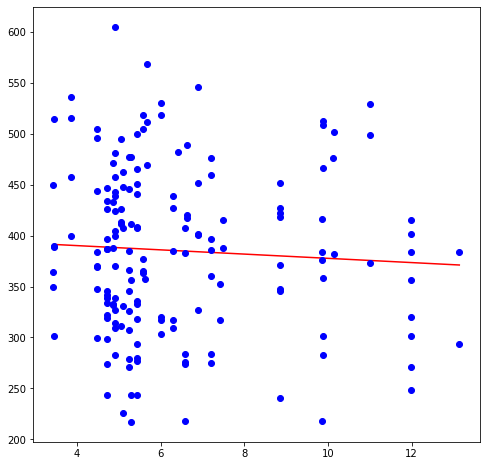

R-squared is 0.0
Beta 1 is -2.08


In [181]:
linReg(pollution_breath['PM2.5'],pollution_breath['PEF(l/min)'])


In [185]:
glm = generalized_linear_model.GLM(pollution_breath['PEF(l/min)'],pollution_breath['PM2.5'],  
                                   family=sm.families.Gaussian())

result = glm.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             PEF(l/min)   No. Observations:                  169
Model:                            GLM   Df Residuals:                      168
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          24536.
Method:                          IRLS   Log-Likelihood:                -1093.4
Date:                Fri, 27 Mar 2020   Deviance:                   4.1220e+06
Time:                        12:49:52   Pearson chi2:                 4.12e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PM2.5         53.1495      1.773     29.973      0.000      49.674      56.625
==============================================================================
"""

In [186]:
from  statsmodels.genmod import generalized_linear_model
glm = generalized_linear_model.GLM(temp_spiro['PEF(l/min)'], temp_spiro['WT08'], family=sm.families.Binomial())

result = glm.fit()
result.summary()
#evidence of WT-08 causing breath to be worse

/home/robin/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/home/robin/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/home/robin/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: invalid value encountered in add
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/home/robin/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             PEF(l/min)   No. Observations:                  141
Model:                            GLM   Df Residuals:                      140
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 27 Mar 2020   Deviance:                   4.5547e+06
Time:                        12:50:27   Pearson chi2:                 8.70e+21
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WT08        2.392e+18   1.73e+07   1.38e+11      0.000    2.39e+18    2.39e+18
==============================================================================
"""

In [234]:
a = list(all_data.columns)
a.remove('PEF(l/min)','FEV1(l)')
a

TypeError: remove() takes exactly one argument (2 given)

In [241]:
Y = all_data[['PEF(l/min)']]
x_col = list(all_data.columns)
x_col.remove('PEF(l/min)')
x_col.remove('FEV1(l)')
x_col
X = all_data[x_col]
X = sm.add_constant(X)

mod = sm.OLS(Y,X)
fii = mod.fit()
p_values = fii.summary()
p_values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PEF(l/min)   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.6812
Date:                Fri, 27 Mar 2020   Prob (F-statistic):              0.725
Time:                        13:42:04   Log-Likelihood:                -812.60
No. Observations:                 141   AIC:                             1645.
Df Residuals:                     131   BIC:                             1675.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   4.34e+04   2.72e+04      1.594      0.113   -1.04e+04    9.72e+04
OZONE                   -10.3307     11.387     -0.907      0.366     -32.857      12.195
PM2.5Queens             -53.5837     54.802     -0.978      0.330    -161.995      54.827
PM2.5Queens Near-road   -34.6435     50.708     -0.683      0.496    -134.956      65.669
AQI                      31.3304     38.127      0.822      0.413     -44.094     106.755
PRCP                     56.2902     35.851      1.570      0.119     -14.633     127.213
WT08                    -45.9713     25.911     -1.774      0.078     -97.229       5.286
TAVG                      2.1403      1.515      1.413      0.160      -0.857       5.137
unixDate                 -2.3520      1.487     -1.582      0.116      -5.293       0.589
unixTime              -3.454e-05      0.000     -0.129      0.898      -0.001       0.000
==============================================================================
Omnibus:                        1.311   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.519   Jarque-Bera (JB):                1.299
Skew:                           0.133   Prob(JB):                        0.522
Kurtosis:                       2.613   Cond. No.                     2.14e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [190]:
pollution_breath.head()

,PM2.5,Date,Time,PEF(l/min),FEV1(l),unixDate,unixTime
unixDate,,,,,,,
18314.0,7.479167,2020/2/22,03:31:00,388.0,2.54,18314.0,12660.0
18314.0,7.479167,2020/2/22,00:08:00,415.0,2.89,18314.0,480.0
18315.0,10.116667,2020/2/23,19:32:00,476.0,2.78,18315.0,70320.0
18316.0,13.137500,2020/2/24,05:13:00,294.0,1.62,18316.0,18780.0
18316.0,13.137500,2020/2/24,15:37:00,384.0,2.49,18316.0,56220.0


In [194]:
Y = pollution_breath['PEF(l/min)']
X = pollution_breath['PM2.5']
X = sm.add_constant(X)

mod = sm.OLS(Y,X)
fii = mod.fit()
p_values = fii.summary()
p_values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PEF(l/min)   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5848
Date:                Fri, 27 Mar 2020   Prob (F-statistic):              0.446
Time:                        13:19:02   Log-Likelihood:                -981.12
No. Observations:                 169   AIC:                             1966.
Df Residuals:                     167   BIC:                             1973.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        398.4753     18.503     21.535      0.000     361.944     435.006
PM2.5         -2.0825      2.723     -0.765      0.446      -7.459       3.294
==============================================================================
Omnibus:                        3.957   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                2.611
Skew:                           0.110   Prob(JB):                        0.271
Kurtosis:                       2.432   Cond. No.                         20.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
#multi-linear regression - investigate further
ols = linear_model.LinearRegression()
X = temp_spiro[['unixDate', 'FEV1(l)', 'unixTime','PRCP','TAVG','WT08']]  # input varialbe
Y = temp_spiro['PEF(l/min)']  # output variable
ols.fit(X, Y)
print("Intercept: %f" %ols.intercept_)
print("Coefficients: %s" %str(ols.coef_))
print("R^2: %f" %(ols.score(X, Y)))
ols.get_params()

Intercept: -14061.406504
Coefficients: [ 7.68021310e-01  1.46647246e+02 -1.39668447e-04 -2.00085216e+01
  2.94322816e-01 -3.86657168e+00]
R^2: 0.828610


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [32]:
mod = sm.OLS(Y,X)
fii = mod.fit()
p_values = fii.summary2()
p_values
#no strong correlation other than FEV

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.992    
Dependent Variable:     PEF(l/min)       AIC:                         1322.4903
Date:                   2020-03-25 17:11 BIC:                         1339.8324
No. Observations:       133              Log-Likelihood:              -655.25  
Df Model:               6                F-statistic:                 2853.    
Df Residuals:           127              Prob (F-statistic):          7.65e-133
R-squared (uncentered): 0.993            Scale:                       1166.3   
-----------------------------------------------------------------------------------
              Coef.       Std.Err.        t        P>|t|       [0.025       0.975] 
-----------------------------------------------------------------------------------
unixDate       0.0004       0.0015      0.2523     0.8012      -0.0026       0.0034
FEV1(l)      144.8441       6.1181     23.6747     0.0000     132.7375     156.9507
unixTime      -0.0001       0.0001     -0.9917     0.3232      -0.0003       0.0001
PRCP         -13.2507      13.5745     -0.9761     0.3308     -40.1121      13.6108
TAVG           0.5633       0.4806      1.1721     0.2433      -0.3877       1.5142
WT08         -11.1143       9.7108     -1.1445     0.2546     -30.3302       8.1016
-------------------------------------------------------------------------------
Omnibus:                   52.561           Durbin-Watson:              2.057  
Prob(Omnibus):             0.000            Jarque-Bera (JB):           313.697
Skew:                      1.197            Prob(JB):                   0.000  
Kurtosis:                  10.133           Condition No.:              255361 
===============================================================================
* The condition number is large (3e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [33]:
#same analysis - different weather source
X = newtemp_spiro[['FEV1(l)','DailyAverageDryBulbTemperature','DailyAverageStationPressure','DailyPrecipitation','unixDate','unixTime']]
Y = newtemp_spiro['PEF(l/min)']  # output variable
ols.fit(X, Y)
print("Intercept: %f" %ols.intercept_)
print("Coefficients: %s" %str(ols.coef_))
print("R^2: %f" %(ols.score(X, Y)))
ols.get_params()
#very similar to above

Intercept: -16633.004984
Coefficients: [ 1.47431994e+02  1.85513748e-01 -1.69166911e+00 -2.31983848e+01
  9.11260269e-01 -1.39833625e-04]
R^2: 0.828448


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}